# 数据

In [8]:
import os
import sys
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import *
from DogsCats import DogsVsCats

data_path = r"D:/code/data/CatsDogs/"
train_folder = data_path + 'train/'
train_filelist = os.listdir(train_folder)
print('train: {0} {1}\n'.format(len(train_filelist), train_filelist[:20]))

test_folder = data_path + 'test/'
test_filelist = os.listdir(test_folder)
print('test: {0} {1}\n'.format(len(test_filelist), test_filelist[:20]))

train: 25000 ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg', 'cat.10005.jpg', 'cat.10006.jpg', 'cat.10007.jpg', 'cat.10008.jpg', 'cat.10009.jpg', 'cat.1001.jpg', 'cat.10010.jpg', 'cat.10011.jpg', 'cat.10012.jpg', 'cat.10013.jpg']

test: 12500 ['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg', '10006.jpg', '10007.jpg', '10008.jpg', '10009.jpg', '1001.jpg', '10010.jpg', '10011.jpg', '10012.jpg', '10013.jpg', '10014.jpg']



In [8]:
# 自定义数据集
class DogsVsCats(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        # 数据集路径列表 计算总数
        imgs = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]
        imgs_num = len(imgs)

        # 数据集划分 train val test
        if split == 'train':
            self.image_paths = imgs[:int(0.8 * imgs_num)]
        elif split == 'val':
            self.image_paths = imgs[int(0.8 * imgs_num):]
        else:
            self.image_paths = imgs
        self.split = split

        # 数据转换
        if transform is None:
            if split == 'train':
                self.transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.Resize((256, 256)),
                    transforms.RandomCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])
            else:
                self.transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 加载图像数据 图像数据转换
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)

        # 图片路径 提取标签信息 转换为张量
        filename = self.image_paths[idx].split('/')[-1]
        if self.split == 'test':
            label = int(filename.split('.')[0])
        else:
            label = 1 if 'dog' in filename else 0
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [9]:
def plot_from_dataset(dataset, shuffle=False, cmap=None):
    dataloader = DataLoader(dataset, batch_size=16, shuffle=shuffle)
    images, labels = next(iter(dataloader))
    images = np.transpose(images, (0, 2, 3, 1))

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap=cmap)
        ax.axis('off')

        if hasattr(dataset, 'classes'):
            ax.set_title(dataset.classes[labels[i]], fontsize=12)
        else:
            ax.set_title(labels[i], fontsize=12)

    plt.show()

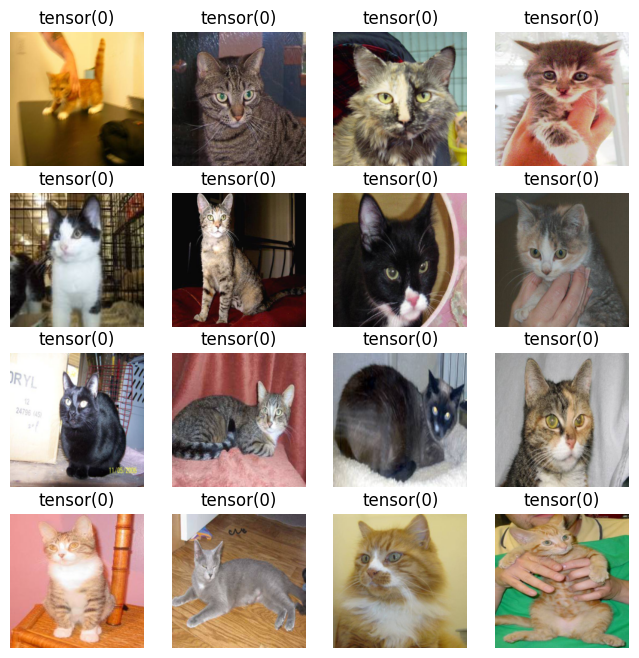

In [10]:
# 验证数据集是否能用
data_dir_train = r"D:\code\data\CatsDogs\train"
dataset = DogsVsCats(
    data_dir_train,
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
)
plot_from_dataset(dataset)

In [11]:
data_dir_train = r"D:/code/data/CatsDogs/train"
data_dir_test = r"D:/code/data/CatsDogs/test"

# 划分数据集 train test val
train_dataset = DogsVsCats(data_dir_train, split='train')
val_dataset = DogsVsCats(data_dir_train, split='val')
test_dataset = DogsVsCats(data_dir_test, split='test')
# 数据加载器
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
# 查看数据集样本数量
len(train_dataset), len(val_dataset), len(test_dataset)

(20000, 5000, 12500)

# 模型训练

In [13]:
class Trainer:
    def __init__(self, model, train_loader, val_loader):
        # 初始化训练集和验证集的数据加载器
        self.train_loader = train_loader
        self.val_loader = val_loader

        # 将数据移动到指定设备上
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)

        # 定义优化器 损失函数 学习率调度器
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()
        self.scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.95)

        # 记录训练的损失 验证的准确率
        self.train_losses = []
        self.val_accuracy = []

    def train(self, num_epochs):
        for epoch in tqdm(range(num_epochs), file=sys.stdout):
            total_loss = 0

            # 批量训练
            self.model.train()
            for images, labels in self.train_loader:
                # 将数据转移到指定设备上
                images = images.to(self.device)
                labels = labels.to(self.device)

                # 预测 损失函数 反向传播
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()

                # 记录训练loss
                total_loss += loss.item()

            # 更新优化器的学习率
            self.scheduler.step()
            # 计算验证集的准确率
            accuracy = self.validate()

            # 记录训练集损失 验证集准确率
            self.train_losses.append(np.log10(total_loss))
            self.val_accuracy.append(accuracy)

            # 打印中间值
            if epoch % 5 == 0:
                tqdm.write('Epoch: {0} Loss: {1} Acc: {2}'.format(epoch, self.train_losses[-1], self.val_accuracy[-1]))

    def validate(self):
        # 测试模型 不计算梯度
        self.model.eval()

        # 记录总数 正确数
        total,correct = 0,0

        with torch.no_grad():
            for images,labels in self.val_loader:
                # 将数据转到指定设备
                images = images.to(self.device)
                labels = labels.to(self.device)

                # 预测
                outputs = self.model(images)
                # 记录验证集总数 预测正确数
                total += labels.size(0)
                correct += (outputs.argmax(1)==labels).sum().item()

        # 返回准确率
        accuracy = correct / total
        return accuracy

In [14]:
if __name__ == '__main__':

    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    # 修改模型的输出层
    num_features = model.fc.in_features
    model.fc = nn.Linear(in_features=num_features,out_features=2,bias=True)

    # 实例化训练
    trainer = Trainer(model,train_loader,val_loader)
    trainer.train(num_epochs=20)

Epoch: 0 Loss: 2.3740109584076827 Acc: 0.9058
Epoch: 5 Loss: 2.3742127671492557 Acc: 0.8998 
Epoch: 10 Loss: 2.3739703574176456 Acc: 0.9042 
Epoch: 15 Loss: 2.3742606780845534 Acc: 0.9042 
100%|██████████| 20/20 [20:30<00:00, 61.55s/it]


In [15]:
trainer.val_accuracy[-1] # 最终准确率

0.8992

# 模型评价

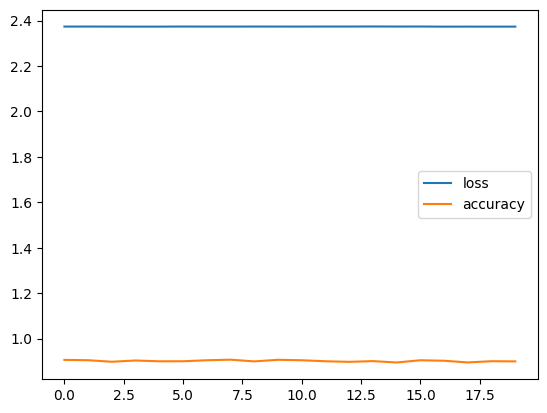

In [16]:
plt.plot(trainer.train_losses,label='loss')
plt.plot(trainer.val_accuracy,label='accuracy')
plt.legend()
plt.show()

# 模型预测

In [17]:
def inference(trainer, test_loader):
    # 模型的评估模式
    trainer.model.eval()

    # 记录测试样本id 模型预测结果
    ids = []
    predictions = []

    with torch.no_grad():
        for images,labels in test_loader:
            images = images.to(trainer.device)
            outputs = trainer.model(images)
            _,predicted = torch.max(outputs.data,1)
            ids.extend(labels.numpy().tolist())
            predictions.extend(predicted.cpu().numpy().tolist())

    return ids,predictions

In [18]:
ids,predictions = inference(trainer,test_loader)
print(predictions[:20]) # 前20个样本的预测结果

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "D:\systemEnvironment\Anaconda3\envs\py38tg1\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "D:\systemEnvironment\Anaconda3\envs\py38tg1\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "D:\systemEnvironment\Anaconda3\envs\py38tg1\lib\site-packages\torch\utils\data\_utils\fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "D:\code\hyz-code-python\code_python_dl\DogsCats.py", line 63, in __getitem__
    label = int(filename.split('.')[0])
ValueError: invalid literal for int() with base 10: 'test\\1'
